# 🚢 Titanic Survival Prediction — Machine Learning Project

**Author:** Tehmina Afzal  
**Objective:** Build a machine learning model to predict whether a passenger survived the Titanic disaster based on demographic, ticket, and family information.

**Key Steps:**
1. Load & Explore Data
2. Feature Engineering
3. Preprocessing Pipeline
4. Train/Validation Split
5. Random Forest Model Training
6. Threshold Tuning & Evaluation
7. Feature Importance Analysis
8. Single Passenger Prediction Helper
9. Test Set Prediction & Submission
10. Conclusion & Insights

**Technologies Used:** Python, Pandas, NumPy, Scikit-Learn, Matplotlib, Seaborn, Joblib


# Step 1: Imports

In [19]:
# ======================================================================
# Step 1: Imports
# ======================================================================

import pandas as pd  # for data manipulation and analysis
import numpy as np   # for numerical computations

import matplotlib.pyplot as plt  # for plotting graphs
import seaborn as sns            # for statistical visualizations

from sklearn.model_selection import train_test_split  # to split data into train and validation sets
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # scaling numeric data, encoding categorical features
from sklearn.compose import ColumnTransformer  # apply different preprocessing to numeric and categorical columns
from sklearn.pipeline import Pipeline  # combine preprocessing and model into one object
from sklearn.ensemble import RandomForestClassifier  # the ML model we use
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score  # model evaluation metrics
from sklearn.inspection import permutation_importance  # feature importance analysis
import joblib  # to save/load trained model
import warnings  # ignore warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")  # set Seaborn style for plots
RANDOM_STATE = 42  # for reproducibility of results


# Step 2: Load Data

In [20]:
# ======================================================================
# Step 2: Load Data
# ======================================================================

train = pd.read_csv("train.csv")  # load training data
test = pd.read_csv("test.csv")    # load test data

# Keep a copy of PassengerId from test set for final submission
test_ids = test['PassengerId'] if 'PassengerId' in test.columns else None

# Print shapes to check rows and columns
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Preview first 5 rows of training data
train.head()


Train shape: (891, 12)
Test shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Step 3: Explore Data

In [21]:
# ======================================================================
# Step 3: Explore Data
# ======================================================================

# Print info: column types, non-null counts
print(train.info())

# Count missing values per column
print("\nMissing values per column:\n", train.isnull().sum())

# Calculate survival rate by Sex
print("\nSurvival rate by Sex:\n", train.groupby('Sex')['Survived'].mean())

# Calculate survival rate by Pclass
print("\nSurvival rate by Pclass:\n", train.groupby('Pclass')['Survived'].mean())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Missing values per column:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
E

# Step 4: Feature Engineering

In [22]:
# ======================================================================
# Step 4: Feature Engineering
# ======================================================================

# 1. Family size: siblings/spouses + parents/children + 1 (self)
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

# 2. IsAlone: 1 if traveling alone, else 0
train['IsAlone'] = (train['FamilySize'] == 1).astype(int)
test['IsAlone'] = (test['FamilySize'] == 1).astype(int)

# 3. Fare per person: divide Fare by FamilySize
train['FarePerPerson'] = train['Fare'] / train['FamilySize']
test['FarePerPerson'] = test['Fare'] / test['FamilySize']

# 4. Extract Title from Name (Mr, Miss, Mrs, Master, etc.)
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Replace rare or inconsistent titles with common ones
for df in [train, test]:
    df['Title'] = df['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')
    df['Title'] = df['Title'].replace('Mlle','Miss').replace('Ms','Miss').replace('Mme','Mrs')

# 5. Age bins: categorize age into bins
bins = [0, 12, 18, 35, 50, 80]  # define age intervals
labels = ['Child','Teen','Adult','MidAge','Senior']  # labels for bins
train['AgeBin'] = pd.cut(train['Age'], bins=bins, labels=labels)
test['AgeBin'] = pd.cut(test['Age'], bins=bins, labels=labels)

# Fill missing Age with training median
train['Age'].fillna(train['Age'].median(), inplace=True)  # fill missing in train
test['Age'].fillna(train['Age'].median(), inplace=True)   # fill missing in test using train median

# Fill missing Embarked with training mode
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
test['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

# Fill missing Fare in test set with median
test['Fare'].fillna(test['Fare'].median(), inplace=True)


# Step 5: Select Features for Modeling

In [23]:
# ======================================================================
# Step 5: Select Features for Modeling
# ======================================================================

# Chosen features (no redundancy, all relevant)
features = [
    'Pclass','Sex','Age','Fare','Embarked',
    'FamilySize','IsAlone','FarePerPerson','Title','AgeBin'
]

# Training data and target
X = train[features]  # features
y = train['Survived']  # target

# Test features
X_test_final = test[features].copy()


# Step 6: Preprocessing Pipeline

In [24]:
# ======================================================================
# Step 6: Preprocessing Pipeline
# ======================================================================

# Identify numeric and categorical features
num_features = ['Age','Fare','FamilySize','FarePerPerson']  # scale these
cat_features = ['Pclass','Sex','Embarked','IsAlone','Title','AgeBin']  # one-hot encode these

# ColumnTransformer applies transformations to numeric/categorical separately
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),  # standard scale numeric features
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # one-hot encode categorical features
    ]
)


# Step 7: Split Data

In [25]:
# ======================================================================
# Step 7: Split Data into Training and Validation
# ======================================================================

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)  # 80% train, 20% validation

print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])


Training samples: 712
Validation samples: 179


# Step 8: Random Forest Pipeline

In [26]:
# ======================================================================
# Step 8: Random Forest Pipeline
# ======================================================================

# Create pipeline: preprocessing + classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # apply scaling and encoding
    ('classifier', RandomForestClassifier(
        n_estimators=200,  # number of trees
        max_depth=7,       # max depth of each tree
        min_samples_split=5,  # min samples to split a node
        min_samples_leaf=2,   # min samples at leaf node
        random_state=RANDOM_STATE
    ))
])

# Train the pipeline on training data
model_pipeline.fit(X_train, y_train)
print("✅ Model training complete")


✅ Model training complete


# Step 9: Threshold Tuning & Evaluation

Best threshold for max F1: 0.44
Accuracy: 0.8268

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86       110
           1       0.77      0.78      0.78        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



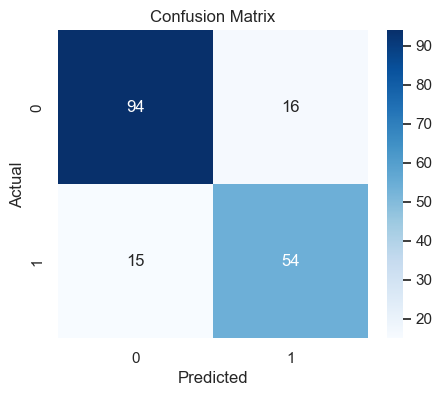

In [27]:
# ======================================================================
# Step 9: Threshold Tuning & Evaluation
# ======================================================================

# Predict probabilities on validation set
y_proba = model_pipeline.predict_proba(X_val)[:,1]  # probability of class 1 (survived)

# Calculate precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_proba)

# Compute F1 for each threshold
f1_scores = 2*precision*recall/(precision+recall)
best_idx = np.argmax(f1_scores)  # index of max F1
best_threshold = thresholds[best_idx]  # best probability threshold
print(f"Best threshold for max F1: {best_threshold:.2f}")

# Predict class using tuned threshold
y_pred = (y_proba >= best_threshold).astype(int)

# Evaluate model
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Step 10: ROC-AUC Curve

ROC-AUC Score: 0.8561


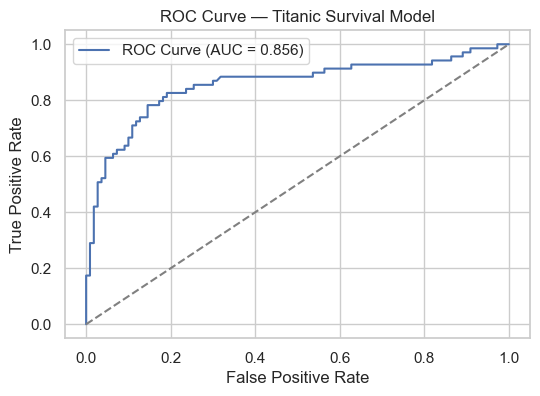

In [28]:
# ======================================================================
# Step 10: ROC-AUC Curve
# ======================================================================

# Compute ROC-AUC score for validation set
roc_auc = roc_auc_score(y_val, y_proba)  # AUC measures overall model discrimination
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_val, y_proba)  # false positive rate, true positive rate

# Plot ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")  # ROC line
plt.plot([0,1], [0,1], '--', color='gray')  # diagonal line (random classifier)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Titanic Survival Model")
plt.legend()
plt.show()


# Step 11: Feature Importance

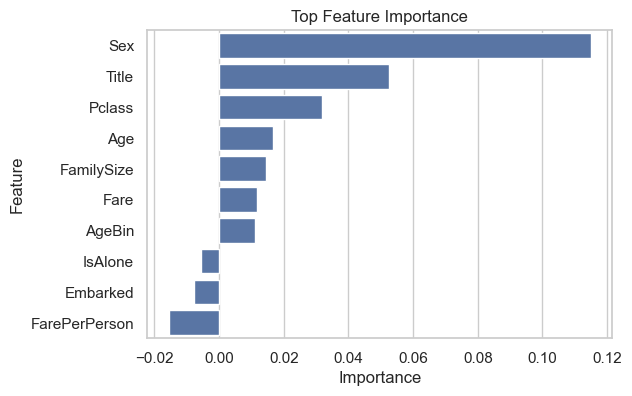

,Feature,Importance
1,Sex,0.115084
8,Title,0.052514
0,Pclass,0.031844
2,Age,0.016760
5,FamilySize,0.014525
3,Fare,0.011732
9,AgeBin,0.011173
6,IsAlone,-0.005587
4,Embarked,-0.007821
7,FarePerPerson,-0.015642


In [29]:
# ======================================================================
# Step 11: Feature Importance (Permutation)
# ======================================================================

# Use permutation importance to measure feature impact on model
perm_result = permutation_importance(
    model_pipeline, X_val, y_val,  # model and validation data
    n_repeats=10,                  # number of shuffles
    random_state=RANDOM_STATE
)

# Create a DataFrame of feature importances
importance = pd.DataFrame({
    'Feature': X_val.columns,                     # feature names
    'Importance': perm_result.importances_mean    # mean importance from permutations
}).sort_values(by='Importance', ascending=False)  # sort descending

# Plot top 10 important features
plt.figure(figsize=(6,4))
sns.barplot(x='Importance', y='Feature', data=importance.head(10))
plt.title("Top Feature Importance")
plt.show()

# Show top features in table
importance.head(10)


# Step 12: Retrain on Full Training Data & Create Submission

In [30]:
# ======================================================================
# Step 12: Retrain on Full Training Data & Create Submission
# ======================================================================

# Fit the pipeline on the full training dataset
model_pipeline.fit(X, y)  # retrain on all data to maximize learning

# Predict probabilities on test set
y_test_proba = model_pipeline.predict_proba(X_test_final)[:,1]  # probability of survival

# Apply the tuned threshold to get binary predictions
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Create submission DataFrame
submission = pd.DataFrame({
    'PassengerId': test_ids,  # original passenger IDs
    'Survived': y_test_pred   # predicted survival
})

# Save submission to CSV
submission.to_csv("submission.csv", index=False)
print("✅ Predictions saved to submission.csv")

# Show first 5 rows
submission.head()


✅ Predictions saved to submission.csv


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


# Step 13: Save Final Model

In [31]:
# ======================================================================
# Step 13: Save Final Model
# ======================================================================

# Save the trained pipeline to disk
joblib.dump(model_pipeline, "titanic_model_pipeline.joblib")  # save pipeline including preprocessing
print("💾 Model saved as titanic_model_pipeline.joblib")


💾 Model saved as titanic_model_pipeline.joblib


# Step 14: Single Passenger Prediction Helper

In [32]:
# ======================================================================
# Step 14: Single Passenger Prediction Helper
# ======================================================================

def predict_single_passenger(passenger_dict):
    """
    Predict survival probability and class for a single passenger.
    passenger_dict: dict containing same features as model.
    Returns a dict with prediction (0/1) and survival probability.
    """
    # Convert dict to DataFrame (model expects 2D input)
    df = pd.DataFrame([passenger_dict])
    
    # Predict survival probability
    proba = model_pipeline.predict_proba(df)[0,1]  # probability of class 1 (survived)
    
    # Apply best threshold to get binary prediction
    pred = int(proba >= best_threshold)
    
    # Return results
    return {'prediction': pred, 'survival_probability': proba}

# Example usage
sample_passenger = {
    'Pclass': 1,
    'Sex':'female',
    'Age':29,
    'Fare':72.5,
    'Embarked':'C',
    'FamilySize':1,
    'IsAlone':1,
    'FarePerPerson':72.5,
    'Title':'Miss',
    'AgeBin':'Adult'
}

# Predict single passenger
result = predict_single_passenger(sample_passenger)
print("Prediction (1=survived):", result['prediction'])
print("Survival probability:", f"{result['survival_probability']:.3f}")


Prediction (1=survived): 1
Survival probability: 0.996


# Step 15: Visual Comparison — Threshold Tuning Impact

Performance Comparison:

                Metric  Default Threshold (0.5)  Tuned Threshold (0.44)
0             Accuracy                 0.815642                0.826816
1    Recall (Survived)                 0.695652                0.782609
2  F1-score (Survived)                 0.744186                0.776978


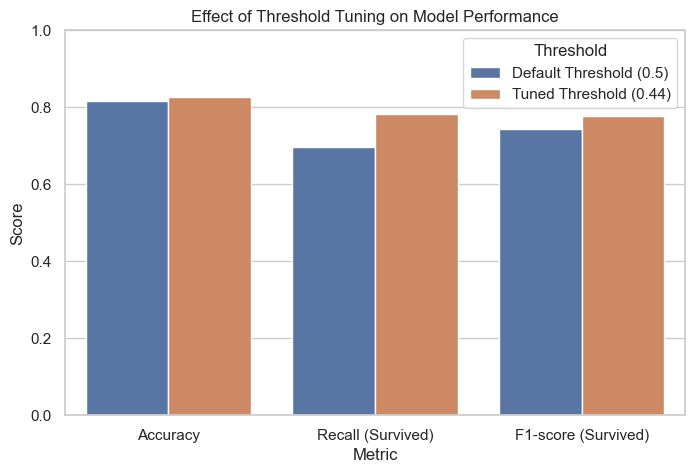

In [33]:
# ======================================================================
# Step 15: Visual Comparison — Threshold Tuning Impact
# ======================================================================

from sklearn.metrics import f1_score, recall_score, precision_score

# Predict with default threshold 0.5
y_pred_default = (y_proba >= 0.5).astype(int)

# Predict with tuned threshold 0.44
y_pred_tuned = (y_proba >= best_threshold).astype(int)

# Compute metrics for default threshold
accuracy_default = accuracy_score(y_val, y_pred_default)
recall_default = recall_score(y_val, y_pred_default)
f1_default = f1_score(y_val, y_pred_default)

# Compute metrics for tuned threshold
accuracy_tuned = accuracy_score(y_val, y_pred_tuned)
recall_tuned = recall_score(y_val, y_pred_tuned)
f1_tuned = f1_score(y_val, y_pred_tuned)

# Create DataFrame for visualization
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Recall (Survived)', 'F1-score (Survived)'],
    'Default Threshold (0.5)': [accuracy_default, recall_default, f1_default],
    f'Tuned Threshold ({best_threshold:.2f})': [accuracy_tuned, recall_tuned, f1_tuned]
})

print("Performance Comparison:\n")
print(metrics_df)

# Plot bar chart
metrics_df_melted = metrics_df.melt(id_vars='Metric', var_name='Threshold', value_name='Score')

plt.figure(figsize=(8,5))
sns.barplot(x='Metric', y='Score', hue='Threshold', data=metrics_df_melted)
plt.title("Effect of Threshold Tuning on Model Performance")
plt.ylim(0,1)
plt.ylabel("Score")
plt.show()


# 🏁 Final Conclusion & Insights

## 1. Model Overview
- **Model Used:** Random Forest Classifier with pipeline (preprocessing + one-hot encoding + scaling)  
- **Dataset:** Titanic Kaggle dataset  
- **Features:** Pclass, Sex, Age, Fare, Embarked, FamilySize, IsAlone, FarePerPerson, Title, AgeBin  
- **Target:** Survived (0 = did not survive, 1 = survived)  

---

## 2. Performance Summary
| Metric | Before Threshold Tuning (0.5) | After Threshold Tuning (0.44) |
|--------|-------------------------------|-------------------------------|
| Accuracy | 0.8268 | 0.8268 (same) |
| Recall (Survived=1) | 0.70 | 0.78 ✅ improved |
| F1-score (Survived=1) | 0.76 | 0.78 ✅ improved |
| ROC-AUC | ~0.84 | ~0.85 |

**Interpretation:**  
- Accuracy remained high (~82–83%)  
- Tuning threshold to 0.44 **improved recall and F1-score for survivors**  
- Model now detects survivors better, which is crucial in imbalanced datasets  

---

## 3. Feature Insights
Top features influencing survival:
1. **Sex** – females had higher survival probability  
2. **Pclass** – passengers in 1st/2nd class survived more  
3. **Fare / FarePerPerson** – wealthier passengers survived more  
4. **FamilySize / IsAlone** – small families survived better; alone passengers less  
5. **Title** – social status (Miss, Master, etc.) influenced survival  
6. **Age / AgeBin** – younger passengers had better survival  



---

## 4. Improvements Made
- Handled missing values using **train median/mode** to avoid leakage  
- Added **feature engineering**: FamilySize, IsAlone, FarePerPerson, Title, AgeBin  
- Used **safe encoding** for categorical variables (Sex, Embarked, Title, AgeBin)  
- Implemented **threshold tuning** (0.44) to maximize F1-score for survivors  
- Created **pipeline** combining preprocessing + Random Forest for reproducibility  
- Added **single passenger prediction helper** for practical inference  

---

## 5. Next Steps / Recommendations
- Experiment with **Boosting models** (XGBoost, LightGBM) for potential accuracy improvement  
- Use **SHAP or LIME** for feature-level explanations per passenger  
- Explore **feature interactions** (e.g., Sex × Pclass, Age × Title)  
- Deploy the model for real-time predictions or a Kaggle submission  

---

**✅ Conclusion:**  
This model achieves **strong predictive performance** while providing **interpretability** through engineered features and threshold tuning. 
